# Initial Imports

In [33]:
import argparse, sys, os, logging
import numpy as np
import pandas as pd
import powergrid_data
from hmmlearn import hmm
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, normalize
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, HourLocator, AutoDateLocator, DateFormatter, AutoDateFormatter, date2num
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

# Test and Train Files Directory

In [34]:
train = 'data/train/train.csv'
test = 'data/test/test_v1.csv'

# Extracting Data from csv files

In [35]:
power_grid = powergrid_data.datasets(train, test)
train_data, test_data = power_grid.data, power_grid.target

# Seperate Features and Dates

> Note: Edit from here onwards

In [36]:
dates_columns = 'DateTime'
features_columns = ['Global_active_power']

parsed_training_date = train_data[dates_columns]
parsed_training_features = train_data[features_columns]

parsed_test_date = test_data[dates_columns]
parsed_test_features = test_data[features_columns]

# Assign the scope to the parser to extract data
> Scope can include years, months, days, hours, minutes and seconds to analyse data you want

In [37]:
months = {'January': 1, 'Feburary': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
days = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

## If you modify year, month and day, make sure the above dates_columns is either Date or DateTime

## Both test and train has data of year 2006, 2007 and 2008
Year = 2007

## Months takes a string of month full name e.g 'March'
Month = 'May'
Day = 'Saturday'

## If you modify hour, minutes and seconds, make sure the above dates_columns is either DateTime or Time
## Hour uses 24 hr clock
Hour = None
Minutes = None
Seconds = None


yearFilter = parsed_training_date.dt.year == Year
monthFilter = parsed_training_date.dt.month == months[Month]
weekendFilter = parsed_training_date.dt.weekday < days[Day]



Filter = yearFilter & monthFilter & weekendFilter

parsed_training_date = parsed_training_date[Filter]
parsed_training_features = parsed_training_features[Filter]


parsed_training_date.reset_index(drop=True, inplace=True)
parsed_training_features.reset_index(drop=True, inplace=True)
train_dates, train_features = parsed_training_date, parsed_training_features

## For Test:
yearFilter = parsed_test_date.dt.year == Year
monthFilter = parsed_test_date.dt.month == months[Month]
weekendFilter = parsed_test_date.dt.weekday < days[Day]



Filter = yearFilter & monthFilter & weekendFilter

parsed_test_date = parsed_test_date[Filter]
parsed_test_features = parsed_test_features[Filter]


parsed_test_date.reset_index(drop=True, inplace=True)
parsed_test_features.reset_index(drop=True, inplace=True)
test_dates, test_features = parsed_test_date, parsed_test_features



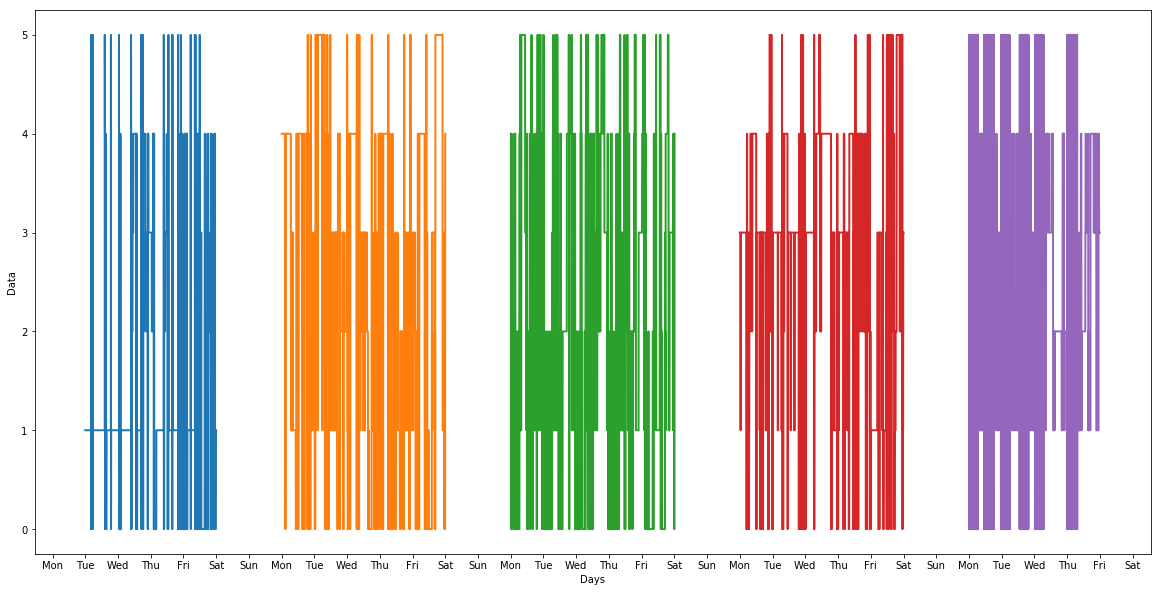

[0 0 5 ..., 3 3 3]
For TRAINING: Means and vars of each hidden state
0th hidden state
mean =  [ 0.24979146]
var =  [ 0.00435177]

1th hidden state
mean =  [ 1.490806]
var =  [ 0.03970751]

2th hidden state
mean =  [ 0.68363864]
var =  [ 0.07715332]

3th hidden state
mean =  [ 2.480231]
var =  [ 0.89106886]

4th hidden state
mean =  [ 1.81338667]
var =  [ 0.04659658]

5th hidden state
mean =  [ 0.52291656]
var =  [ 0.00220433]



In [72]:
thresh = 2

weeks = train_dates.dt.week.unique()

height = 10
width = 20

fig, ax = plt.subplots()
fig.set_size_inches(width, height)



for week in weeks:
    
    weekFilter = train_dates.dt.week == week    
    
    filtered_train_dates = train_dates[weekFilter]
    filtered_train_features = train_features[weekFilter]
    
#     weekendFilter = filtered_train_dates.dt.dayofweek < 5 # Monday=0, Sunday=6

#     filtered_train_dates = filtered_train_dates[weekendFilter]
#     filtered_train_features = filtered_train_features[weekendFilter]
    
    filtered_train_dates.reset_index(drop=True, inplace=True)
    filtered_train_features.reset_index(drop=True, inplace=True)
    
   
    x = filtered_train_dates.values.astype(datetime)
    y = filtered_train_features.values.flatten()
    
    model = hmm.GaussianHMM(n_components=6, covariance_type="full", n_iter=1000, tol=thresh).fit(filtered_train_features)
    model.predict(filtered_train_features)
    result = model.decode(filtered_train_features, algorithm='viterbi')[1]

    ax.plot(filtered_train_dates, result, linewidth=2)

#     filtered = lowess(y, x, frac=0.05)
#     ax.plot(filtered_train_dates, filtered[:, 1], linewidth=2)

    formatter=DateFormatter('%a')
    ax.set_xticks(filtered_train_dates.values)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(DayLocator())
    
ax.set_xlabel('Days')
ax.set_ylabel('Data')
plt.show()

print(result)
print("For TRAINING: Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()
    

In [74]:
# Fit Test Data into Model
for week in weeks:
    
    weekFilter = test_dates.dt.week == week    
    
    filtered_test_dates = test_dates[weekFilter]
    filtered_test_features = test_features[weekFilter]
    
#     weekendFilter = filtered_train_dates.dt.dayofweek < 5 # Monday=0, Sunday=6

#     filtered_train_dates = filtered_train_dates[weekendFilter]
#     filtered_train_features = filtered_train_features[weekendFilter]
    
    filtered_test_dates.reset_index(drop=True, inplace=True)
    filtered_test_features.reset_index(drop=True, inplace=True)
    
   
    x = filtered_test_dates.values.astype(datetime)
    y = filtered_test_features.values.flatten()
    
    test_model = hmm.GaussianHMM(n_components=6, covariance_type="full", n_iter=1000, tol=0).fit(filtered_test_features)
    model.predict(filtered_test_features)
    t_result = model.decode(filtered_test_features, algorithm='viterbi')[1]

    # store hidden states for test set as applied/derived from trained model
    #test_meandiff = t_result - model.means[t_result==model.n_components]
    
    ax.plot(filtered_test_dates, t_result, linewidth=2)

#     filtered = lowess(y, x, frac=0.05)
#     ax.plot(filtered_train_dates, filtered[:, 1], linewidth=2)

    formatter=DateFormatter('%a')
    ax.set_xticks(filtered_test_dates.values)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(DayLocator())
    
ax.set_xlabel('Days')
ax.set_ylabel('Data')
plt.show()

print("For TEST:")
print("States of Test Data: ")
print(t_result)
print("Raw Data: ")
print(filtered_test_features)
print("Mean for State assigned to Test Data: ")
print(model.means_[t_result])
print("Difference")
print(thresh >= (filtered_test_features - model.means_[t_result]))

# If within reasonable range, normal; Else, anomaly...
# Print results and score to output file
    

For TEST:
States of Test Data: 
[2 2 3 ..., 2 2 2]
Raw Data: 
      Global_active_power
0                2.087184
1                1.026000
2                2.318000
3                2.315550
4                1.943035
5                2.309000
6                2.110000
7                2.271600
8                2.258650
9                2.252700
10               2.158000
11               4.842135
12               3.300810
13               2.227600
14               2.216150
15               2.202500
16               3.632513
17               2.171700
18               2.177700
19               2.169700
20               2.316000
21               2.434000
22               2.402000
23               5.217278
24               2.700000
25               2.394000
26               2.051950
27               2.022350
28               2.250000
29               1.550164
...                   ...
5730             0.164000
5731             0.164000
5732             0.603700
5733             0.607500
57

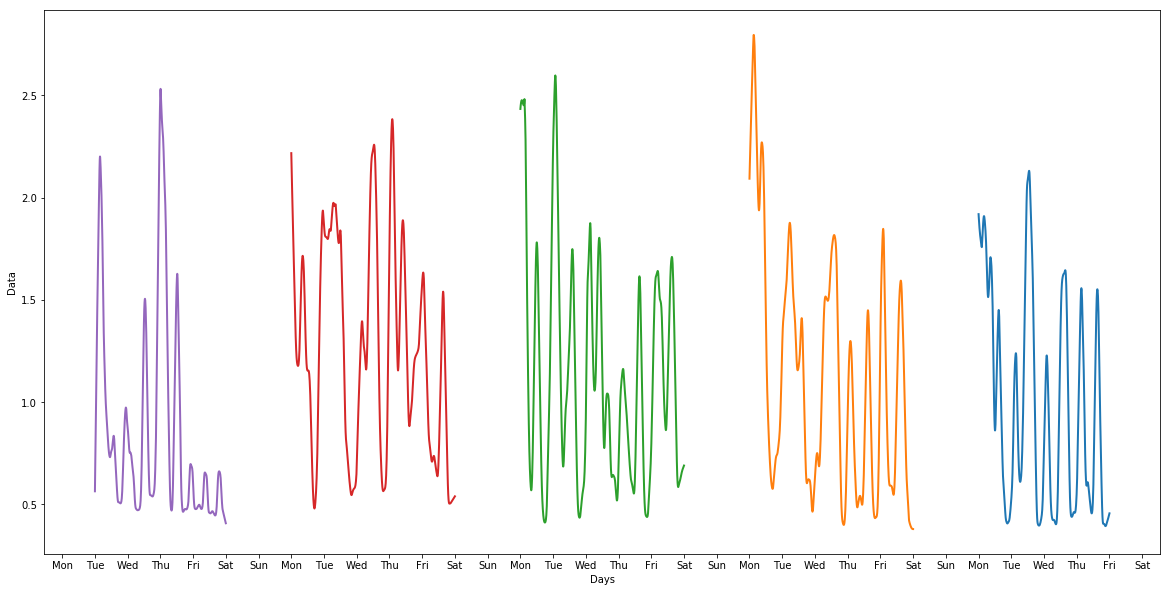

In [21]:
weeks = train_dates.dt.week.unique()

height = 10
width = 20

fig, ax = plt.subplots()
fig.set_size_inches(width, height)

for week in weeks:
    
    weekFilter = train_dates.dt.week == week    
    
    filtered_train_dates = train_dates[weekFilter]
    filtered_train_features = train_features[weekFilter]
    
#     weekendFilter = filtered_train_dates.dt.dayofweek < 5 # Monday=0, Sunday=6

#     filtered_train_dates = filtered_train_dates[weekendFilter]
#     filtered_train_features = filtered_train_features[weekendFilter]
    
    filtered_train_dates.reset_index(drop=True, inplace=True)
    filtered_train_features.reset_index(drop=True, inplace=True)
    
   
    x = filtered_train_dates.values.astype(datetime)
    y = filtered_train_features.values.flatten()
    
    filtered = lowess(y, x, frac=0.05)
    ax.plot(filtered_train_dates, filtered[:, 1], linewidth=2)

    formatter=DateFormatter('%a')
    ax.set_xticks(filtered_train_dates.values)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(DayLocator())
    
ax.set_xlabel('Days')
ax.set_ylabel('Data')
plt.show()

    
    
    
    

In [8]:
lag_plot(train_features)
plt.show()

NameError: name 'lag_plot' is not defined

In [9]:
values = pd.DataFrame(train_features.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.71406
t+1  0.71406  1.00000


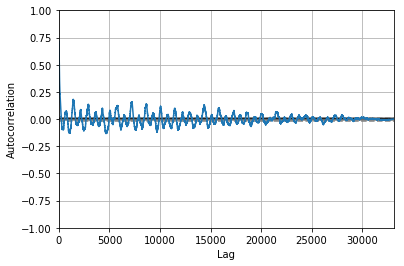

In [10]:
autocorrelation_plot(train_features)
plt.show()

Test MSE: 0.028


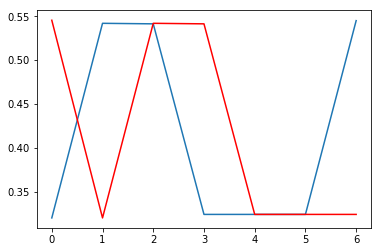

In [11]:
from sklearn.metrics import mean_squared_error

values = pd.DataFrame(train_features.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    

test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

Lag: 51
Coefficients: [ 0.07168733  0.20493043  0.13842376  0.08895893  0.08815495  0.08499156
  0.06104943  0.04859676  0.03972004  0.02878976  0.02119248  0.02423594
  0.01887539  0.01266326  0.01134491  0.01707379  0.00843071  0.02343092
  0.01193856  0.01530462  0.00243124  0.01197816  0.00771612  0.01494922
  0.00611775  0.00918621  0.00034031  0.00090307  0.006594   -0.00133986
 -0.00698735 -0.00081857  0.00134179  0.01070801  0.00188296  0.00195012
 -0.00211012 -0.00129503 -0.00942423 -0.01082865 -0.00672386 -0.00520221
 -0.005273    0.00496372 -0.00637573 -0.01257657 -0.00869629  0.00584893
  0.00125589 -0.00276234 -0.00966037 -0.0035539 ]
predicted=0.686736, expected=0.320000
predicted=0.654350, expected=0.541850
predicted=0.641871, expected=0.541250
predicted=0.656493, expected=0.324000
predicted=0.689527, expected=0.324000
predicted=0.672758, expected=0.324000
predicted=0.690389, expected=0.544900
Test MSE: 0.078


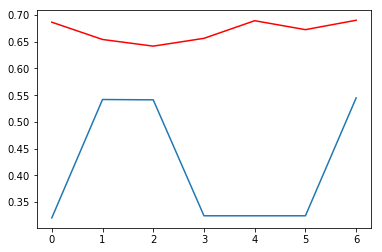

In [12]:

from statsmodels.tsa.ar_model import AR

# split dataset
X = train_features.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()